In [24]:
from pyvrp import Model, Client, Depot
from research.utils.types import TCoordinate
from research.utils.service_time import service_time_for_vehicle_to_unload
from research.utils.distance import calculate_distance
from research.utils.duration import HIGH_PROFILE_DATA
import pandas as pd
from functools import partial

In [32]:
high_profile_data = pd.read_csv("data/wltc/class3-2a-Medium.csv", names=["time", "speed"])

high_profile_data[(600 <= high_profile_data["time"]) & (high_profile_data["time"] <= 986)]

,time,speed
10,600.0,0.0
11,601.0,1.0
12,602.0,2.1
13,603.0,5.2
14,604.0,9.2
...,...,...
392,982.0,7.2
393,983.0,5.5
394,984.0,3.2
395,985.0,1.1


<Axes: xlabel='time'>

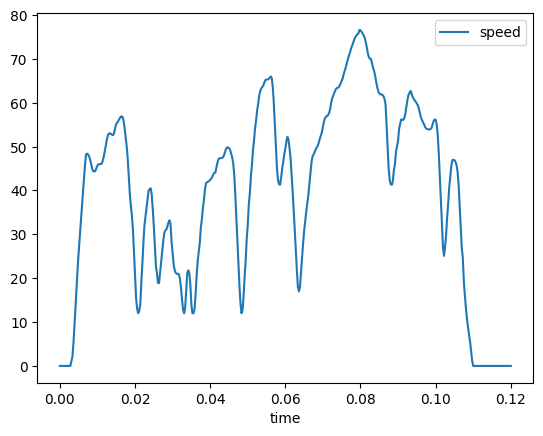

In [27]:
high_profile_data = pd.read_csv("data/wltc/class3-2a-Medium.csv", names=["time", "speed"])
high_profile_data['time'] -= high_profile_data.loc[0, "time"]
high_profile_data['time'] /= 3600

high_profile_data.plot(x="time", y="speed")

In [6]:
# An initialization of a Model object for solving.
m = Model()

In [ ]:
# Problem Setup
# Coordinates of the locations (depot and customers)
# Depot must be first in the list. If multiple depots are used, they should be listed first.
# Each coordinate is a tuple (x, y) representing the location in a 2D space.


COORDINATES: list[TCoordinate] = [
    # Some arbitrary coordinates for the depot and customers
    (0, 0),  # Depot
    (1, 2),  # Customer 1
    (2, 3),  # Customer 2
    (3, 1),  # Customer 3
    (4, 4),  # Customer 4
]

DEMANDS = [0, 5, 10, 15, 20]  # Demands for each customer

LARGE_VEHICLE_CAPACITY = sum(DEMANDS) / 3  # Large vehicle capacity for the problem
SMALL_VEHICLE_CAPACITY = 10  # Small vehicle capacity for the problem
LARGE_VEHICLE_FULL_UNLOAD_TIME = 10.0  # Time for a large vehicle to unload completely
SMALL_VEHICLE_FULL_UNLOAD_TIME = 1.0  # Time for a small vehicle to unload completely

MINIMUM_WORKING_HOURS = 8
WAGE_PER_HOUR = 20.0  # Wage per hour for the drivers

In [ ]:
depot: Depot = m.add_depot( # Adding the depot to the model
    x = COORDINATES[0][0], 
    y = COORDINATES[0][1],
)
service_time_for_demand = partial(
    service_time_for_vehicle_to_unload,
    small_vehicle_full_unload_time=SMALL_VEHICLE_FULL_UNLOAD_TIME,
    large_vehicle_full_unload_time=LARGE_VEHICLE_FULL_UNLOAD_TIME,
    small_vehicle_capacity=SMALL_VEHICLE_CAPACITY,
    large_vehicle_capacity=LARGE_VEHICLE_CAPACITY
)
clients: list[Client] = []
for coord, demand in zip(COORDINATES[1:], DEMANDS[1:], strict=True):
    client: Client = m.add_client(
        x=coord[0], 
        y=coord[1], 
        delivery=[demand], 
        service_duration=service_time_for_demand(demand)
    )  # Adding customers to the model
    clients.append(client)

In [ ]:
# Wages is a funky calculation but is rather fixed in structure.
# This must be re-implemented in C++ to plug straight into the solver.
def calculate_wage(duration: float) -> float:
    """
    Calculate the wage for a client based on the duration.
    The wage is calculated as the maximum of the minimum working hours multiplied by the wage per hour
    and the duration multiplied by the wage per hour.
    If the duration is less than the minimum working hours, the wage is set to the minimum working hours.
    """
    return max(MINIMUM_WORKING_HOURS * WAGE_PER_HOUR, duration * WAGE_PER_HOUR)

In [ ]:
ALL_NODES = [depot] + clients  # All nodes in the model, including depot and clients
for node_i, node_j in zip(ALL_NODES, ALL_NODES, strict=True): 
    distance = calculate_distance((node_i.x, node_i.y), (node_j.x, node_j.y))
    # Based on distance, we add duration using the WLTC velocity profile.
    m.add_edge(node_i, node_j, distance)  # Adding the calculated distance to the model
    # Note: We still have not included the duration aspect in the node. This would be done once a velocity profile is defined.
    # For now, we skip it.